In [1]:
# Import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab as py
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import families
import statsmodels.formula.api as smf
import scipy.stats

# allow multiple outputs in jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display to show all rows
pd.set_option('display.max_rows', None)

# set display to show all columns
pd.set_option("display.max.columns", None)

### Load County Health Rankings Data

In [2]:
# import data into county_health_data data frame
county_health_rank = pd.read_csv('Datasets/county_health_2021.csv')

# rename headers using 1st row of data
county_health_rank = county_health_rank.rename(columns=county_health_rank.iloc[0])

# delete 1st row (which is now a duplicate of the header)
county_health_rank = county_health_rank.drop(county_health_rank.index[0])

# view first 5 rows of county_health_data data frame (note that there appears to be no index 0)
#county_health_rank.head()

# select only desired columns
cols = ['statecode', 'countycode', 'fipscode', 'state', 'county', 'v166_rawvalue', 'v003_rawvalue', 'v004_rawvalue', 'v153_rawvalue',
        'v060_rawvalue', 'v154_rawvalue', 'v062_rawvalue', 'v132_rawvalue', 'v005_rawvalue', 'v061_rawvalue']

county_health_rank = county_health_rank[cols]

# view first 5 rows
county_health_rank.head()

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

,statecode,countycode,fipscode,state,county,v166_rawvalue,v003_rawvalue,v004_rawvalue,v153_rawvalue,v060_rawvalue,v154_rawvalue,v062_rawvalue,v132_rawvalue,v005_rawvalue,v061_rawvalue
1,00,000,00000,US,United States,0.826664922,0.1244966054,0.0007581256,0.6399214141,0.105,0.1443735922,0.002612056,0.8416869169,4236,372.8
2,01,000,01000,AL,Alabama,0.7639912993,0.1514929638,0.0006520221,0.6878059932,0.145,0.1205779357,0.0010829695,0.6111228737,5466,330.4
3,01,001,01001,AL,Autauga County,0.8056736926,0.1300796103,0.0004676175,0.7329064822,0.127,0.1337588929,0.0002863842,0.6913012406,6650,230.2
4,01,003,01003,AL,Baldwin County,0.8181638453,0.1675343756,0.000701764,0.7524527369,0.103,0.1117404539,0.000985513,0.7371354895,3471,169.3
5,01,005,01005,AL,Barbour County,0.6052434457,0.1767323062,0.0003215305,0.608988764,0.175,0.1427071179,0.0001215264,0.5316676986,5314,471


In [3]:
# rename variables
county_health_rank.rename(columns={"v166_rawvalue": "broadband", "v003_rawvalue": "uninsured_adults", "v004_rawvalue": "primary_phys",
                                   "v153_rawvalue": "home_ownership", "v060_rawvalue": "diabetes", "v154_rawvalue": 'severe_housing_cost', 
                                   "v132_rawvalue": "access_exercise", "v062_rawvalue": "mental_hlth", "v005_rawvalue": "prevent_hosp_stay",
                                   "v061_rawvalue": "HIV_prev"}, inplace=True)
# select variables
select = ["broadband","uninsured_adults","primary_phys","home_ownership","diabetes","severe_housing_cost", "access_exercise", 
          "mental_hlth", "prevent_hosp_stay","HIV_prev"]

# determine data type of above variables
#county_health_rank[select].dtypes

# convert data type of above variables from object to float or int
county_health_rank[select] = county_health_rank[select].astype(float)
county_health_rank['fipscode'] = county_health_rank['fipscode'].astype(int)

# determine data type of above variables
county_health_rank[select].dtypes

broadband              float64
uninsured_adults       float64
primary_phys           float64
home_ownership         float64
diabetes               float64
severe_housing_cost    float64
access_exercise        float64
mental_hlth            float64
prevent_hosp_stay      float64
HIV_prev               float64
dtype: object

### Load Excess Deaths Data

In [4]:
# import data into excess deaths data frame
deaths = pd.read_csv('Datasets/ExcessDeaths_Obesity.csv')

# rename columns
deaths.rename(columns={'CountyName': 'county_name', 'TOTPOP_CY': 'total_county_pop', 'Deaths': 'total_deaths', 
                              'Expected': 'expected_deaths', 'Abnormal': 'abnormal_deaths', 'Excess': 'excess_deaths'}, inplace=True)

# check data type of Excess deaths column
deaths['excess_deaths'].dtypes

# select only desired columns
cols_2 = ['ID','county_name','State','total_county_pop','total_deaths','expected_deaths','abnormal_deaths','excess_deaths','COVID19']
deaths = deaths[cols_2]

# display first 5 rows
deaths.head()

dtype('int64')

,ID,county_name,State,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19
0,1001,Autauga County,AL,57692,404,387,17,17,28
1,1003,Baldwin County,AL,219443,1775,1841,-66,0,94
2,1005,Barbour County,AL,27401,220,232,-12,0,16
3,1007,Bibb County,AL,23276,155,196,-41,0,19
4,1009,Blount County,AL,59231,397,541,-144,0,12


### Load Google Street View Features Data

In [5]:
# import google street view file
gsv = pd.read_csv('Datasets/gsv_indicators_summarized_county.csv')

# rename columns
gsv.rename(columns={'county': 'fipscode'}, inplace=True)

# first 5 rows
gsv.head()

# check data type of county column
gsv['fipscode'].dtypes

,fipscode,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building
0,1001,0.969148,0.005288,0.089308,0.677698,0,0.343879,0.085365,0.083976
1,1003,0.947018,0.007764,0.116095,0.677067,0,0.436140,0.108644,0.097183
2,1005,0.978433,0.004444,0.102145,0.665148,0,0.277878,0.043388,0.071833
3,1007,0.992821,0.002094,0.046022,0.732843,0,0.242073,0.035595,0.054354
4,1009,0.972386,0.002662,0.115099,0.674392,0,0.358319,0.032216,0.087506


dtype('int64')

### Load County Shapefile

In [6]:
# read in counties shapefile
counties = gpd.read_file('Shapefiles/county_files/tl_2021_us_county.shp')

# first 5 rows
counties.head()

# convert GEOID column to integer
counties['GEOID'] = counties['GEOID'].astype(int)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477645345,10690204,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680976231,61568965,+46.2946377,-123.4244583,"POLYGON ((-123.49077 46.38358, -123.48813 46.3..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.38368 34.69213, -104.37658 34.6..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169272970,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68140 41.04566, -96.68139 41.045..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.04802 40.35066, -98.04674 40.350..."


### Load MSA Shapefile

In [7]:
# read in MSA shapefile
MSA = gpd.read_file('Shapefiles/MSA_files/tl_2021_us_cbsa.shp')

In [8]:
# convert GEOID and MEMI column to integer
MSA['GEOID'] = MSA['GEOID'].astype(int)
MSA['MEMI'] = MSA['MEMI'].astype(int)

# remove unecessary columns
MSA.drop(['CSAFP', 'CBSAFP', 'ALAND','AWATER', 'MTFCC', 'INTPTLAT', 'INTPTLON'], axis=1, inplace=True)

# remove micropolitan statistical areas by filtering
MSA.drop(MSA.index[MSA['MEMI'] == 2], inplace=True)

# check that drop was successful
MSA.head()

,GEOID,NAME,NAMELSAD,LSAD,MEMI,geometry
0,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,"POLYGON ((-83.36003 34.04057, -83.36757 34.043..."
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991..."
2,12100,"Atlantic City-Hammonton, NJ","Atlantic City-Hammonton, NJ Metro Area",M1,1,"POLYGON ((-74.58640 39.30989, -74.58665 39.309..."
6,12220,"Auburn-Opelika, AL","Auburn-Opelika, AL Metro Area",M1,1,"POLYGON ((-85.16535 32.47097, -85.16725 32.470..."
7,12260,"Augusta-Richmond County, GA-SC","Augusta-Richmond County, GA-SC Metro Area",M1,1,"POLYGON ((-81.65176 33.81451, -81.64701 33.818..."


### Load State Shapefile

In [9]:
# read in states shapefile
states = gpd.read_file('Shapefiles/state_files/cb_2018_us_state_20m.shp')

# first 5 rows
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


In [10]:
# convert GEOID column to integer
states['GEOID'] = states['GEOID'].astype(int)

# remove unecessary columns
states.drop(['STATENS', 'AFFGEOID', 'LSAD','ALAND','AWATER'], axis=1, inplace=True)

#rename variables
states.rename(columns={"STUSPS": "state_short", "NAME": "state_long"}, inplace=True)

# check that drop was successful
states.head()

,STATEFP,GEOID,state_short,state_long,geometry
0,24,24,MD,Maryland,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,19,IA,Iowa,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,10,DE,Delaware,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,39,OH,Ohio,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,42,PA,Pennsylvania,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


### Join datasets together

In [11]:
# join excess deaths and county health rankings dataframes
excess_county_hlth = pd.merge(county_health_rank,deaths,left_on='fipscode',right_on='ID')

# remove duplicate columns
excess_county_hlth.drop(['ID', 'county_name', 'State'], axis=1, inplace=True)

# check results
excess_county_hlth.head()

# drop rows with NaN
excess_county_hlth = excess_county_hlth.dropna()
excess_county_hlth.isna().sum().sum() #check if successful

,statecode,countycode,fipscode,state,county,broadband,uninsured_adults,primary_phys,home_ownership,diabetes,severe_housing_cost,mental_hlth,access_exercise,prevent_hosp_stay,HIV_prev,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19
0,01,001,1001,AL,Autauga County,0.805674,0.130080,0.000468,0.732906,0.127,0.133759,0.000286,0.691301,6650.0,230.2,57692,404,387,17,17,28
1,01,003,1003,AL,Baldwin County,0.818164,0.167534,0.000702,0.752453,0.103,0.111740,0.000986,0.737135,3471.0,169.3,219443,1775,1841,-66,0,94
2,01,005,1005,AL,Barbour County,0.605243,0.176732,0.000322,0.608989,0.175,0.142707,0.000122,0.531668,5314.0,471.0,27401,220,232,-12,0,16
3,01,007,1007,AL,Bibb County,0.692062,0.134299,0.000536,0.744159,0.136,0.087444,0.000268,0.162514,6690.0,235.0,23276,155,196,-41,0,19
4,01,009,1009,AL,Blount County,0.730081,0.179347,0.000207,0.787787,0.146,0.078048,0.000173,0.156345,4440.0,90.9,59231,397,541,-144,0,12


0

In [12]:
# Merge counties and gsv_features
gsv_counties = pd.merge(counties, gsv, left_on='GEOID', right_on='fipscode')

gsv_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,fipscode,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477645345,10690204,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914...",31039,0.500000,0.000000,1.000000,0.500000,0,1.000000,0.000000,0.000000
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680976231,61568965,+46.2946377,-123.4244583,"POLYGON ((-123.49077 46.38358, -123.48813 46.3...",53069,0.974623,0.005155,0.201031,0.327914,0,0.308485,0.056305,0.139175
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.38368 34.69213, -104.37658 34.6...",35011,0.380463,0.006846,0.699842,0.629015,0,0.535545,0.019747,0.230121
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169272970,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68140 41.04566, -96.68139 41.045...",31109,0.865250,0.017866,0.226208,0.769947,0,0.448079,0.283628,0.170508
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.04802 40.35066, -98.04674 40.350...",31129,0.649414,0.009766,0.507324,0.574219,0,0.596680,0.147949,0.259766


In [13]:
# join gsv_counties and excess_county_hlth dataframes
gsv_deaths_hlth = pd.merge(gsv_counties, excess_county_hlth, left_on='GEOID', right_on='fipscode')

# remove unecessary columns
gsv_deaths_hlth.drop(['STATEFP', 'COUNTYFP', 'fipscode_x','statecode','countycode','fipscode_y','county', 'LSAD', 'CLASSFP',
                     'MTFCC','CSAFP','METDIVFP','FUNCSTAT','CBSAFP', 'ALAND', 'AWATER'], axis=1, inplace=True)

# rename columns
gsv_deaths_hlth.rename(columns={'NAME': 'county_short', 'NAMELSAD': 'county_long'}, inplace=True)

# first 5 rows
gsv_deaths_hlth.head()

,COUNTYNS,GEOID,county_short,county_long,INTPTLAT,INTPTLON,geometry,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building,state,broadband,uninsured_adults,primary_phys,home_ownership,diabetes,severe_housing_cost,mental_hlth,access_exercise,prevent_hosp_stay,HIV_prev,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19
0,00835876,31109,Lancaster,Lancaster County,+40.7835474,-096.6886584,"POLYGON ((-96.68140 41.04566, -96.68139 41.045...",0.865250,0.017866,0.226208,0.769947,0,0.448079,0.283628,0.170508,NE,0.877039,0.096995,0.000706,0.597986,0.082,0.120426,0.003833,0.969030,3245.0,29.5,323229,2343,1744,599,599,101
1,00277310,6091,Sierra,Sierra County,+39.5769252,-120.5219926,"POLYGON ((-120.55587 39.50874, -120.55614 39.5...",0.813906,0.008691,0.410020,0.587935,0,0.389059,0.135481,0.368098,CA,0.748294,0.080593,0.000335,0.753601,0.070,0.197205,0.001664,0.701852,2310.0,227.5,3214,28,33,-5,0,0
2,00161539,1027,Clay,Clay County,+33.2703999,-085.8635254,"POLYGON ((-85.65202 33.25238, -85.65203 33.251...",0.977837,0.001753,0.090541,0.706123,0,0.159953,0.013172,0.091575,AL,0.701039,0.198139,0.000377,0.754521,0.162,0.071677,0.000151,0.637812,6054.0,175.5,13802,159,138,21,21,30
3,00069902,5137,Stone,Stone County,+35.8570011,-092.1404819,"POLYGON ((-91.99105 35.93176, -91.99091 35.931...",0.978604,0.001973,0.126176,0.548027,0,0.294537,0.039074,0.108118,AR,0.506163,0.149020,0.000482,0.746396,0.144,0.126306,0.001040,0.575036,5178.0,92.7,13352,134,134,0,0,15
4,00695754,28061,Jasper,Jasper County,+32.0167482,-089.1191761,"POLYGON ((-89.07939 31.81659, -89.08322 31.816...",0.997150,0.001080,0.027659,0.835633,0,0.263575,0.022380,0.034109,MS,0.451803,0.181789,0.000183,0.850355,0.209,0.065872,0.000122,0.298851,6254.0,342.0,17339,165,177,-12,0,0


In [14]:
# remove NaN and check
gsv_deaths_hlth = gsv_deaths_hlth.dropna()
gsv_deaths_hlth.isna().sum().sum()

0

In [15]:
# second dataset with MSA 

# join counties and MSA together
gsv_hlth_MSA = gpd.sjoin(MSA, gsv_deaths_hlth, how="inner", op='contains')

# check join
gsv_hlth_MSA.head()

,GEOID_left,NAME,NAMELSAD,LSAD,MEMI,geometry,index_right,COUNTYNS,GEOID_right,county_short,county_long,INTPTLAT,INTPTLON,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building,state,broadband,uninsured_adults,primary_phys,home_ownership,diabetes,severe_housing_cost,mental_hlth,access_exercise,prevent_hosp_stay,HIV_prev,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19
0,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,"POLYGON ((-83.36003 34.04057, -83.36757 34.043...",443,01672699,13059,Clarke,Clarke County,+33.9521852,-083.3671522,0.970527,0.017657,0.155454,0.721504,0,0.350442,0.223759,0.153519,GA,0.823684,0.209806,0.000675,0.390263,0.074,0.240583,0.002712,0.822601,4720.0,369.9,129895,1358,603,755,755,147
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",261,00346892,13199,Meriwether,Meriwether County,+33.0292666,-084.6670579,0.983937,0.002837,0.090860,0.676507,0,0.295430,0.065787,0.104585,GA,0.599553,0.207087,0.000332,0.684884,0.187,0.127574,0.000898,0.396963,6236.0,308.5,22444,216,231,-15,0,0
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",457,00346144,13159,Jasper,Jasper County,+33.3169807,-083.6891515,0.991860,0.001628,0.091235,0.644829,0,0.234501,0.043436,0.093709,GA,0.733127,0.236977,0.000356,0.768323,0.131,0.118998,0.000422,0.707986,3340.0,171.0,14501,118,136,-18,0,0
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",15,00326713,13171,Lamar,Lamar County,+33.0744405,-084.1466893,0.990505,0.003391,0.088018,0.697890,0,0.327430,0.063225,0.086285,GA,0.709732,0.183360,0.000316,0.692485,0.169,0.150848,0.000681,0.508216,6051.0,284.2,18735,123,169,-46,0,14
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",445,00326666,13077,Coweta,Coweta County,+33.3528965,-084.7621381,0.979537,0.011647,0.149564,0.667276,0,0.328137,0.135785,0.149779,GA,0.855482,0.164173,0.000466,0.728279,0.136,0.106951,0.000768,0.505259,4029.0,209.8,148655,839,848,-9,0,59


In [17]:
# rename columns
gsv_hlth_MSA.rename(columns={'NAME': 'MSA_short', 'NAMELSAD': 'MSA_long'}, inplace=True)

# check renaming
gsv_hlth_MSA.head()

# remove NaN and check
gsv_hlth_MSA = gsv_hlth_MSA.dropna()
gsv_hlth_MSA.isna().sum().sum()

,GEOID_left,MSA_short,MSA_long,LSAD,MEMI,geometry,index_right,COUNTYNS,GEOID_right,county_short,county_long,INTPTLAT,INTPTLON,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building,state,broadband,uninsured_adults,primary_phys,home_ownership,diabetes,severe_housing_cost,mental_hlth,access_exercise,prevent_hosp_stay,HIV_prev,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19
0,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,"POLYGON ((-83.36003 34.04057, -83.36757 34.043...",443,01672699,13059,Clarke,Clarke County,+33.9521852,-083.3671522,0.970527,0.017657,0.155454,0.721504,0,0.350442,0.223759,0.153519,GA,0.823684,0.209806,0.000675,0.390263,0.074,0.240583,0.002712,0.822601,4720.0,369.9,129895,1358,603,755,755,147
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",261,00346892,13199,Meriwether,Meriwether County,+33.0292666,-084.6670579,0.983937,0.002837,0.090860,0.676507,0,0.295430,0.065787,0.104585,GA,0.599553,0.207087,0.000332,0.684884,0.187,0.127574,0.000898,0.396963,6236.0,308.5,22444,216,231,-15,0,0
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",457,00346144,13159,Jasper,Jasper County,+33.3169807,-083.6891515,0.991860,0.001628,0.091235,0.644829,0,0.234501,0.043436,0.093709,GA,0.733127,0.236977,0.000356,0.768323,0.131,0.118998,0.000422,0.707986,3340.0,171.0,14501,118,136,-18,0,0
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",15,00326713,13171,Lamar,Lamar County,+33.0744405,-084.1466893,0.990505,0.003391,0.088018,0.697890,0,0.327430,0.063225,0.086285,GA,0.709732,0.183360,0.000316,0.692485,0.169,0.150848,0.000681,0.508216,6051.0,284.2,18735,123,169,-46,0,14
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",445,00326666,13077,Coweta,Coweta County,+33.3528965,-084.7621381,0.979537,0.011647,0.149564,0.667276,0,0.328137,0.135785,0.149779,GA,0.855482,0.164173,0.000466,0.728279,0.136,0.106951,0.000768,0.505259,4029.0,209.8,148655,839,848,-9,0,59


0

## Exploratory Data Analysis

### Exploratory plots

In [ ]:
# create histogram of available excess health data
y = excess_deaths['Excess']

# convert all excess death values that are 0 to 1
y[y==0] = 1

# remove all rows that = 1
y = y[y!= 1]

# plot histogram of log y
plt.hist(np.log(y))

# add title and axis labels
plt.title('Distribution of Excess Deaths')
plt.xlabel('Log(excess deaths)')
plt.ylabel('Frequency')

#plt.savefig('available excess deaths data.png')

In [ ]:
# map of prop of greenery by county
f, ax = plt.subplots(1,1,figsize=(20,20))
gsv_counties.plot(column='prop_green', ax=ax, k=5, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})

# add title
plt.title('Proportion of Greenery by County', fontsize=20)

In [ ]:
# map of prop of sidewalk by county

f, ax = plt.subplots(1,1,figsize=(20,20))
gsv_counties.plot('prop_sidewalk', ax=ax, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})

# add title
plt.title('Proportion of Sidewalk by County', fontsize=20)

In [ ]:
# map of prop of single lange roads by county

f, ax = plt.subplots(1,1,figsize=(20,20))
gsv_counties.plot('prop_single_lane', ax=ax, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})

# add title
plt.title('Proportion of Single Lane Roads by County', fontsize=20)

### Variable Refinement

In [18]:
# check correlation btwn independent variables
gsv_deaths_hlth[['prop_green', 'prop_crosswalk', 'prop_not_single_family_house', 'prop_single_lane', 
                 'prop_sidewalk', 'prop_dilapidated_building', 'broadband', 'uninsured_adults', 
                 'primary_phys', 'home_ownership', 'excess_deaths']].corr()

,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_sidewalk,prop_dilapidated_building,broadband,uninsured_adults,primary_phys,home_ownership,excess_deaths
prop_green,1.000000,-0.353461,-0.900129,0.322575,-0.272459,-0.585689,-0.231495,0.207809,-0.112067,0.231537,-0.120775
prop_crosswalk,-0.353461,1.000000,0.495062,-0.294539,0.851340,0.595257,0.417061,-0.182108,0.441990,-0.542030,0.565753
prop_not_single_family_house,-0.900129,0.495062,1.000000,-0.441897,0.365717,0.660208,0.265337,-0.176279,0.202855,-0.327631,0.204622
prop_single_lane,0.322575,-0.294539,-0.441897,1.000000,-0.097068,-0.280421,-0.190420,0.216564,-0.125151,-0.023478,-0.033783
prop_sidewalk,-0.272459,0.851340,0.365717,-0.097068,1.000000,0.592387,0.503025,-0.200713,0.469205,-0.552593,0.586705
prop_dilapidated_building,-0.585689,0.595257,0.660208,-0.280421,0.592387,1.000000,0.477029,-0.204626,0.343509,-0.290232,0.316463
broadband,-0.231495,0.417061,0.265337,-0.190420,0.503025,0.477029,1.000000,-0.438384,0.446795,-0.120497,0.199672
uninsured_adults,0.207809,-0.182108,-0.176279,0.216564,-0.200713,-0.204626,-0.438384,1.000000,-0.304955,-0.127001,0.002321
primary_phys,-0.112067,0.441990,0.202855,-0.125151,0.469205,0.343509,0.446795,-0.304955,1.000000,-0.335023,0.245051
home_ownership,0.231537,-0.542030,-0.327631,-0.023478,-0.552593,-0.290232,-0.120497,-0.127001,-0.335023,1.000000,-0.372619


In [19]:
# calculate VIF

# store independent variables in X_1
X_1 = gsv_deaths_hlth[['prop_green', 'prop_crosswalk', 'prop_not_single_family_house', 'prop_single_lane', 'prop_sidewalk',
                 'prop_dilapidated_building','broadband', 'uninsured_adults', 'primary_phys', 'home_ownership']]
# remove NAs
X_1 = X_1.dropna()
  
# create VIF dataframe
vif_data = pd.DataFrame()
vif_data['Variable'] = X_1.columns
  
# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_1.values, i) for i in range(len(X_1.columns))]

# display sorted results
vif_data.sort_values(by=['VIF'])

,Variable,VIF
8,primary_phys,6.899830
1,prop_crosswalk,8.246954
7,uninsured_adults,9.393924
4,prop_sidewalk,10.070279
2,prop_not_single_family_house,10.181047
5,prop_dilapidated_building,13.448125
3,prop_single_lane,66.896128
9,home_ownership,102.957114
6,broadband,111.445733
0,prop_green,172.568442


In [20]:
# recalculate VIF

# store independent variables in X
X_3 = gsv_deaths_hlth[['prop_crosswalk', 'prop_not_single_family_house', 'uninsured_adults','mental_hlth','HIV_prev']]

# remove NaN
X_3 = X_3.dropna()
  
# create VIF dataframe
vif_data = pd.DataFrame()
vif_data['Variable'] = X_3.columns
  
# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_3.values, i) for i in range(len(X_3.columns))]

# display sorted results 
vif_data.sort_values(by=['VIF'])

,Variable,VIF
3,mental_hlth,2.363326
4,HIV_prev,2.932133
2,uninsured_adults,3.047858
0,prop_crosswalk,3.537539
1,prop_not_single_family_house,3.896763


In [21]:
# calculate correlations in new selection of variables
new_corr = gsv_deaths_hlth[['excess_deaths','prop_crosswalk', 'prop_not_single_family_house','uninsured_adults','mental_hlth','HIV_prev']].corr()
new_corr

,excess_deaths,prop_crosswalk,prop_not_single_family_house,uninsured_adults,mental_hlth,HIV_prev
excess_deaths,1.000000,0.565753,0.204622,0.002321,0.195646,0.367589
prop_crosswalk,0.565753,1.000000,0.495062,-0.182108,0.446770,0.492833
prop_not_single_family_house,0.204622,0.495062,1.000000,-0.176279,0.274808,0.078663
uninsured_adults,0.002321,-0.182108,-0.176279,1.000000,-0.338722,0.212719
mental_hlth,0.195646,0.446770,0.274808,-0.338722,1.000000,0.198044
HIV_prev,0.367589,0.492833,0.078663,0.212719,0.198044,1.000000


### Check distributions of variables

(array([395.,  96.,  33.,  12.,   3.,   4.,   1.,   1.,   0.,   2.]),
 array([0.        , 0.01303829, 0.02607658, 0.03911486, 0.05215315,
        0.06519144, 0.07822973, 0.09126802, 0.1043063 , 0.11734459,
        0.13038288]),
 <BarContainer object of 10 artists>)

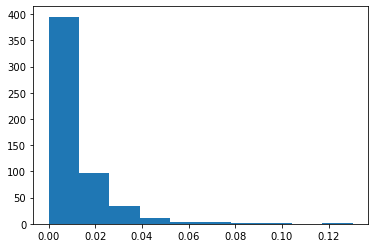

In [22]:
# plot histogram of distribution for prop crosswalk 
plt.hist(gsv_deaths_hlth['prop_crosswalk'])

(array([ 48., 217., 141.,  58.,  35.,  17.,  12.,  11.,   4.,   4.]),
 array([0.        , 0.08409334, 0.16818667, 0.25228001, 0.33637335,
        0.42046669, 0.50456002, 0.58865336, 0.6727467 , 0.75684003,
        0.84093337]),
 <BarContainer object of 10 artists>)

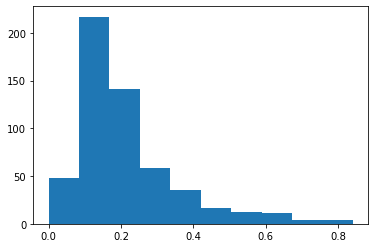

In [23]:
# plot histogram of distribution for prop not single family house
plt.hist(gsv_deaths_hlth['prop_not_single_family_house'])

(array([ 62., 124., 114.,  94.,  77.,  50.,  20.,   4.,   1.,   1.]),
 array([0.03267761, 0.06403028, 0.09538296, 0.12673563, 0.1580883 ,
        0.18944098, 0.22079365, 0.25214633, 0.283499  , 0.31485168,
        0.34620435]),
 <BarContainer object of 10 artists>)

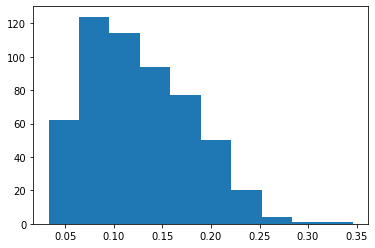

In [24]:
# plot histogram of distribution for uninsured adults
plt.hist(gsv_deaths_hlth['uninsured_adults'])

(array([297., 145.,  63.,  24.,   8.,   4.,   5.,   0.,   0.,   1.]),
 array([3.00716000e-05, 1.48089306e-03, 2.93171452e-03, 4.38253598e-03,
        5.83335744e-03, 7.28417890e-03, 8.73500036e-03, 1.01858218e-02,
        1.16366433e-02, 1.30874647e-02, 1.45382862e-02]),
 <BarContainer object of 10 artists>)

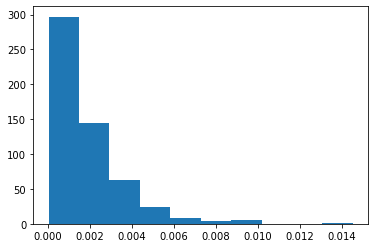

In [25]:
# plot histogram of distribution for mental health providers
plt.hist(gsv_deaths_hlth['mental_hlth'])

(array([404., 103.,  22.,   8.,   6.,   1.,   1.,   1.,   0.,   1.]),
 array([  16.5 ,  250.93,  485.36,  719.79,  954.22, 1188.65, 1423.08,
        1657.51, 1891.94, 2126.37, 2360.8 ]),
 <BarContainer object of 10 artists>)

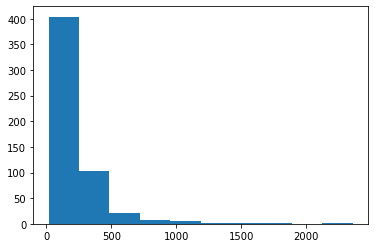

In [26]:
# plot histogram of distribution for HIV prevelance
plt.hist(gsv_deaths_hlth['HIV_prev'])

(array([518.,  16.,   7.,   2.,   1.,   0.,   0.,   1.,   1.,   1.]),
 array([    0. ,  1298.9,  2597.8,  3896.7,  5195.6,  6494.5,  7793.4,
         9092.3, 10391.2, 11690.1, 12989. ]),
 <BarContainer object of 10 artists>)

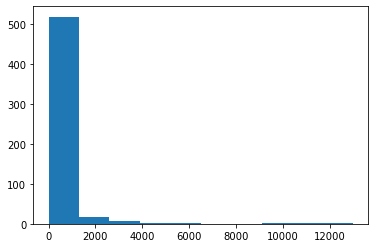

In [27]:
# plot histogram of distribution for excess deaths
plt.hist(gsv_deaths_hlth['excess_deaths'])

## Fixed Effect Models

In [17]:
# counties, state model
smf.glm('excess_deaths ~ prop_crosswalk + prop_not_single_family_house + uninsured_adults + mental_hlth + C(state) + HIV_prev', 
                 gsv_deaths_hlth, family=families.Poisson()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          excess_deaths   No. Observations:                  547
Model:                            GLM   Df Residuals:                      511
Model Family:                 Poisson   Df Model:                           35
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1459e+05
Date:                Wed, 15 Dec 2021   Deviance:                   2.2771e+05
Time:                        03:36:15   Pearson chi2:                 3.19e+05
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        2.3481      0.026     90.326      0.000       2.297       2.399
C(state)[T.AR]                   1.0079      0.029     34.427      0.000       0.951       1.065
C(state)[T.AZ]                   3.6179      0.026    140.625      0.000       3.568       3.668
C(state)[T.CA]                   1.8488      0.027     69.759      0.000       1.797       1.901
C(state)[T.CO]                   1.0692      0.029     37.152      0.000       1.013       1.126
C(state)[T.CT]                   2.8777      0.030     97.264      0.000       2.820       2.936
C(state)[T.DC]                  -1.5575      0.037    -41.990      0.000      -1.630      -1.485
C(state)[T.DE]                   2.4265      0.043     56.454      0.000       2.342       2.511
C(state)[T.FL]                   1.1984      0.023     52.112      0.000       1.153       1.243
C(state)[T.GA]                  -0.2216      0.025     -8.776      0.000      -0.271      -0.172
C(state)[T.HI]                   3.4409      0.044     77.915      0.000       3.354       3.527
C(state)[T.IA]                   1.5128      0.040     38.258      0.000       1.435       1.590
C(state)[T.ID]                   0.8681      0.048     18.275      0.000       0.775       0.961
C(state)[T.IL]                   2.3793      0.024     97.289      0.000       2.331       2.427
C(state)[T.IN]                   1.4913      0.026     58.330      0.000       1.441       1.541
C(state)[T.KS]                   1.0089      0.033     30.276      0.000       0.944       1.074
C(state)[T.KY]                   3.4942      0.030    116.297      0.000       3.435       3.553
C(state)[T.LA]                   0.6902      0.033     20.800      0.000       0.625       0.755
C(state)[T.MA]                   3.3479      0.030    113.362      0.000       3.290       3.406
C(state)[T.MD]                   2.4188      0.026     92.109      0.000       2.367       2.470
C(state)[T.ME]                   0.3419      0.072      4.751      0.000       0.201       0.483
C(state)[T.MI]                   1.9589      0.026     76.122      0.000       1.908       2.009
C(state)[T.MN]                   0.9092      0.042     21.862      0.000       0.828       0.991
C(state)[T.MO]                   0.3842      0.030     12.663      0.000       0.325       0.444
C(state)[T.MS]                  -0.4940      0.032    -15.652      0.000      -0.556      -0.432
C(state)[T.MT]                   1.8280      0.053     34.666      0.000       1.725       1.931
C(state)[T.NE]                   1.8201      0.046     39.948      0.000       1.731       1.909
C(state)[T.NH]                 -25.3099   1.88e+04     -0.001      0.999   -3.68e+04    3.68e+04
C(state)[T.NJ]                   2.0593      0.026     78.494      0.000    

In [18]:
# county, MSA model
smf.glm("excess_deaths ~ prop_crosswalk + prop_not_single_family_house + uninsured_adults + mental_hlth + C(MSA_short) + HIV_prev", 
                 gsv_hlth_MSA, family=families.Poisson()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          excess_deaths   No. Observations:                  251
Model:                            GLM   Df Residuals:                      104
Model Family:                 Poisson   Df Model:                          146
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22307.
Date:                Wed, 15 Dec 2021   Deviance:                       43431.
Time:                        03:36:28   Pearson chi2:                 5.26e+04
No. Iterations:                    30                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        2.1487      0.066     32.575      0.000       2.019       2.278
C(MSA_short)[T.Alexandria, LA]                                 -57.1772   1.16e+05     -0.000      1.000   -2.28e+05    2.28e+05
C(MSA_short)[T.Ann Arbor, MI]                                    2.1427      0.065     33.005      0.000       2.015       2.270
C(MSA_short)[T.Athens-Clarke County, GA]                         0.7921      0.059     13.530      0.000       0.677       0.907
C(MSA_short)[T.Atlanta-Sandy Springs-Alpharetta, GA]            -0.3293      0.049     -6.658      0.000      -0.426      -0.232
C(MSA_short)[T.Auburn-Opelika, AL]                               1.4317      0.083     17.164      0.000       1.268       1.595
C(MSA_short)[T.Augusta-Richmond County, GA-SC]                 -28.4967   6.66e+04     -0.000      1.000   -1.31e+05     1.3e+05
C(MSA_short)[T.Baltimore-Columbia-Towson, MD]                    2.6840      0.058     46.238      0.000       2.570       2.798
C(MSA_short)[T.Barnstable Town, MA]                             -0.2312      0.149     -1.556      0.120      -0.522       0.060
C(MSA_short)[T.Baton Rouge, LA]                                -28.7028   6.43e+04     -0.000      1.000   -1.26e+05    1.26e+05
C(MSA_short)[T.Birmingham-Hoover, AL]                          -28.0719   8.14e+04     -0.000      1.000    -1.6e+05    1.59e+05
C(MSA_short)[T.Bloomington, IL]                                  2.1864      0.104     20.954      0.000       1.982       2.391
C(MSA_short)[T.Bloomington, IN]                                -28.0013   1.16e+05     -0.000      1.000   -2.28e+05    2.28e+05
C(MSA_short)[T.Boise City, ID]                                 -26.9343   1.16e+05     -0.000      1.000   -2.28e+05    2.28e+05
C(MSA_short)[T.Boston-Cambridge-Newton, MA-NH]                   2.6281      0.072     36.519      0.000       2.487       2.769
C(MSA_short)[T.Boulder, CO]                                      1.1341      0.077     14.793      0.000       0.984       1.284
C(MSA_short)[T.Cape Girardeau, MO-IL]                          -28.6128   1.16e+05     -0.000      1.000   -2.28e+05    2.28e+05
C(MSA_short)[T.Carbondale-Marion, IL]                            1.6253      0.091     17.813      0.000       1.446       1.804
C(MSA_short)[T.Carson City, NV]                                 -0.8239      0.080    -10.334      0.000      -0.980      -0.668
C(MSA_short)[T.Cedar Rapids, IA]                                 3.0230      0.077     39.455      0.000       2.873       3.173
C(MSA_short)[T.Champaign-Urbana, IL]                           -25.8273   1.16e+05     -0.000      1.000   -2.28e+05

## Cleaning Model Output for Visualization

### County/state model

In [28]:
# save county/state model results
model_state = smf.glm("excess_deaths ~ prop_crosswalk + prop_not_single_family_house + uninsured_adults + mental_hlth + C(state) + HIV_prev", 
                 gsv_deaths_hlth, family=families.Poisson()).fit()

In [29]:
# select model coefficients, save to new dataframe
state_mod_coef = pd.DataFrame(data = model_state.params, columns=['Coefficient'])

# reset index
state_mod_coef.reset_index(level=0, inplace=True)

# rename state column
state_mod_coef.rename(columns = {'index':'Variable'}, inplace = True)

# convert data type
state_mod_coef['Variable'] = state_mod_coef['Variable'].astype('str')

# display column data types
state_mod_coef.dtypes

# select model p-values, save to new dataframe
state_mod_pval = pd.DataFrame(data = model_state.pvalues, columns=['P-Values'])

# reset index
state_mod_pval.reset_index(level=0, inplace=True)

# rename state column
state_mod_pval.rename(columns = {'index':'Variable'}, inplace = True)

# convert data type
state_mod_pval['Variable'] = state_mod_pval['Variable'].astype('str')

Variable        object
Coefficient    float64
dtype: object

In [30]:
# join coefficient and p-value dataframes 
state_mod = state_mod_coef.merge(state_mod_pval, how='inner', left_on='Variable', right_on='Variable')

state_mod.head(8)

,Variable,Coefficient,P-Values
0,Intercept,2.348094,0.000000e+00
1,C(state)[T.AR],1.007929,1.000845e-259
2,C(state)[T.AZ],3.617947,0.000000e+00
3,C(state)[T.CA],1.848819,0.000000e+00
4,C(state)[T.CO],1.069239,4.086483e-302
5,C(state)[T.CT],2.877748,0.000000e+00
6,C(state)[T.DC],-1.557484,0.000000e+00
7,C(state)[T.DE],2.426505,0.000000e+00


In [31]:
# replace 'Intercept' with 'AL'
state_mod['Variable'].replace(to_replace='Intercept', value='AL', inplace=True)

# extract just state abbreviation from variable column
for i in range(len(state_mod)):
    if 'C(state)' in state_mod['Variable'].iloc[i]:
        state_mod['Variable'].iloc[i] = state_mod['Variable'].iloc[i][11:]
        state_mod['Variable'].iloc[i] = state_mod['Variable'].iloc[i][:-1]
    i+=1
    
#sort values
state_mod = state_mod.sort_values(by=['Variable'])

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [32]:
# get names of indexes where variable is non-state   
index_names = state_mod[(state_mod['Variable'] == 'prop_crosswalk') | (state_mod['Variable'] == 'prop_not_single_family_house') | 
                       (state_mod['Variable'] == 'uninsured_adults') | (state_mod['Variable'] == 'mental_hlth') | 
                       (state_mod['Variable'] == 'HIV_prev')].index
  
# drop these row indexes from dataframe to only have state-associated info
state_mod.drop(index_names, inplace = True)
state_mod

,Variable,Coefficient,P-Values
0,AL,2.348094,0.000000e+00
1,AR,1.007929,1.000845e-259
2,AZ,3.617947,0.000000e+00
3,CA,1.848819,0.000000e+00
4,CO,1.069239,4.086483e-302
5,CT,2.877748,0.000000e+00
6,DC,-1.557484,0.000000e+00
7,DE,2.426505,0.000000e+00
8,FL,1.198399,0.000000e+00
9,GA,-0.221635,1.689868e-18


In [33]:
# join state model dataframe and state shapefile dataframe
state_mod_geo = pd.merge(states, state_mod, how='left', left_on='state_short', right_on='Variable')

#check join
state_mod_geo.head(20)

,STATEFP,GEOID,state_short,state_long,geometry,Variable,Coefficient,P-Values
0,24,24,MD,Maryland,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",MD,2.418797,0.000000e+00
1,19,19,IA,Iowa,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",IA,1.512807,0.000000e+00
2,10,10,DE,Delaware,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",DE,2.426505,0.000000e+00
3,39,39,OH,Ohio,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",NaN,NaN,NaN
4,42,42,PA,Pennsylvania,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",NaN,NaN,NaN
5,31,31,NE,Nebraska,"POLYGON ((-104.05314 41.11446, -104.05245 41.2...",NE,1.820051,0.000000e+00
6,53,53,WA,Washington,"MULTIPOLYGON (((-123.23715 48.68347, -123.0704...",NaN,NaN,NaN
7,72,72,PR,Puerto Rico,"MULTIPOLYGON (((-65.34207 18.34529, -65.25593 ...",NaN,NaN,NaN
8,01,1,AL,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",AL,2.348094,0.000000e+00
9,05,5,AR,Arkansas,"POLYGON ((-94.61792 36.49941, -94.36120 36.499...",AR,1.007929,1.000845e-259


### County/MSA model

In [34]:
# save county/MSA model results
model_MSA = smf.glm("excess_deaths ~ prop_crosswalk + prop_not_single_family_house + uninsured_adults + mental_hlth + C(MSA_short) + HIV_prev", 
                 gsv_hlth_MSA, family=families.Poisson()).fit()

In [35]:
# select model coefficients, save to new dataframe
MSA_mod_coef = pd.DataFrame(data = model_MSA.params, columns=['Coefficient'])

# reset index
MSA_mod_coef.reset_index(level=0, inplace=True)

# rename state column
MSA_mod_coef.rename(columns = {'index':'Variable'}, inplace = True)

# convert data type
MSA_mod_coef['Variable'] = MSA_mod_coef['Variable'].astype('str')

# display column data types
MSA_mod_coef.dtypes

# select model p-values, save to new dataframe
MSA_mod_pval = pd.DataFrame(data = model_MSA.pvalues, columns=['P-Values'])

# reset index
MSA_mod_pval.reset_index(level=0, inplace=True)

# rename state column
MSA_mod_pval.rename(columns = {'index':'Variable'}, inplace = True)

# convert data type
MSA_mod_pval['Variable'] = MSA_mod_pval['Variable'].astype('str')

Variable        object
Coefficient    float64
dtype: object

In [36]:
# join coefficient and p-value dataframes 
MSA_mod = MSA_mod_coef.merge(MSA_mod_pval, how='inner', left_on='Variable', right_on='Variable')

MSA_mod.head(8)

,Variable,Coefficient,P-Values
0,Intercept,2.148737,9.330724e-233
1,"C(MSA_short)[T.Alexandria, LA]",-57.177241,9.996075e-01
2,"C(MSA_short)[T.Ann Arbor, MI]",2.142692,6.836397e-239
3,"C(MSA_short)[T.Athens-Clarke County, GA]",0.792060,1.038026e-41
4,C(MSA_short)[T.Atlanta-Sandy Springs-Alpharett...,-0.329341,2.772284e-11
5,"C(MSA_short)[T.Auburn-Opelika, AL]",1.431668,4.935969e-66
6,"C(MSA_short)[T.Augusta-Richmond County, GA-SC]",-28.496691,9.996585e-01
7,"C(MSA_short)[T.Baltimore-Columbia-Towson, MD]",2.684013,0.000000e+00


In [37]:
# determine which MSA the intercept represents
gsv_hlth_MSA.sort_values(by=['MSA_short']).head()

In [38]:
# replace 'Intercept' with 'Albany, GA'
MSA_mod['Variable'].replace(to_replace='Intercept', value='Albany, GA', inplace=True)

# extract just state abbreviation from variable column
for i in range(len(MSA_mod)):
    if 'C(MSA_short)' in MSA_mod['Variable'].iloc[i]:
        MSA_mod['Variable'].iloc[i] = MSA_mod['Variable'].iloc[i][15:]
        MSA_mod['Variable'].iloc[i] = MSA_mod['Variable'].iloc[i][:-1]
    i+=1
    
#sort values
MSA_mod = MSA_mod.sort_values(by=['Variable'])
#MSA_mod

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [39]:
# get names of indexes where variable is non-state   
index_names = MSA_mod[(MSA_mod['Variable'] == 'prop_crosswalk') | (MSA_mod['Variable'] == 'prop_not_single_family_house') | 
                       (MSA_mod['Variable'] == 'uninsured_adults') | (MSA_mod['Variable'] == 'mental_hlth') | 
                       (MSA_mod['Variable'] == 'HIV_prev')].index
  
# drop these row indexes from dataframe to only have state-associated info
MSA_mod.drop(index_names, inplace = True)
MSA_mod

,Variable,Coefficient,P-Values
0,"Albany, GA",2.148737,9.330724e-233
1,"Alexandria, LA",-57.177241,9.996075e-01
2,"Ann Arbor, MI",2.142692,6.836397e-239
3,"Athens-Clarke County, GA",0.792060,1.038026e-41
4,"Atlanta-Sandy Springs-Alpharetta, GA",-0.329341,2.772284e-11
5,"Auburn-Opelika, AL",1.431668,4.935969e-66
6,"Augusta-Richmond County, GA-SC",-28.496691,9.996585e-01
7,"Baltimore-Columbia-Towson, MD",2.684013,0.000000e+00
8,"Barnstable Town, MA",-0.231171,1.197475e-01
9,"Baton Rouge, LA",-28.702847,9.996437e-01


In [40]:
# join MSA model dataframe and MSA shapefile dataframe
MSA_mod_geo = pd.merge(MSA, MSA_mod, how='left', left_on='NAME', right_on='Variable')

#check join
MSA_mod_geo.head(20)

,GEOID,NAME,NAMELSAD,LSAD,MEMI,geometry,Variable,Coefficient,P-Values
0,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,"POLYGON ((-83.36003 34.04057, -83.36757 34.043...","Athens-Clarke County, GA",0.792060,1.038026e-41
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...","Atlanta-Sandy Springs-Alpharetta, GA",-0.329341,2.772284e-11
2,12100,"Atlantic City-Hammonton, NJ","Atlantic City-Hammonton, NJ Metro Area",M1,1,"POLYGON ((-74.58640 39.30989, -74.58665 39.309...",NaN,NaN,NaN
3,12220,"Auburn-Opelika, AL","Auburn-Opelika, AL Metro Area",M1,1,"POLYGON ((-85.16535 32.47097, -85.16725 32.470...","Auburn-Opelika, AL",1.431668,4.935969e-66
4,12260,"Augusta-Richmond County, GA-SC","Augusta-Richmond County, GA-SC Metro Area",M1,1,"POLYGON ((-81.65176 33.81451, -81.64701 33.818...","Augusta-Richmond County, GA-SC",-28.496691,9.996585e-01
5,12420,"Austin-Round Rock-Georgetown, TX","Austin-Round Rock-Georgetown, TX Metro Area",M1,1,"POLYGON ((-97.31582 29.78654, -97.31634 29.786...",NaN,NaN,NaN
6,12540,"Bakersfield, CA","Bakersfield, CA Metro Area",M1,1,"POLYGON ((-118.88168 34.81785, -118.88204 34.8...",NaN,NaN,NaN
7,12580,"Baltimore-Columbia-Towson, MD","Baltimore-Columbia-Towson, MD Metro Area",M1,1,"POLYGON ((-76.56945 39.72118, -76.56938 39.721...","Baltimore-Columbia-Towson, MD",2.684013,0.000000e+00
8,12620,"Bangor, ME","Bangor, ME Metro Area",M1,1,"POLYGON ((-68.18069 45.23717, -68.18093 45.237...",NaN,NaN,NaN
9,12700,"Barnstable Town, MA","Barnstable Town, MA Metro Area",M1,1,"POLYGON ((-70.69096 41.66046, -70.68832 41.665...","Barnstable Town, MA",-0.231171,1.197475e-01


## Coefficient Model Visualizations

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

(-180.0, -65.0)

No handles with labels found to put in legend.


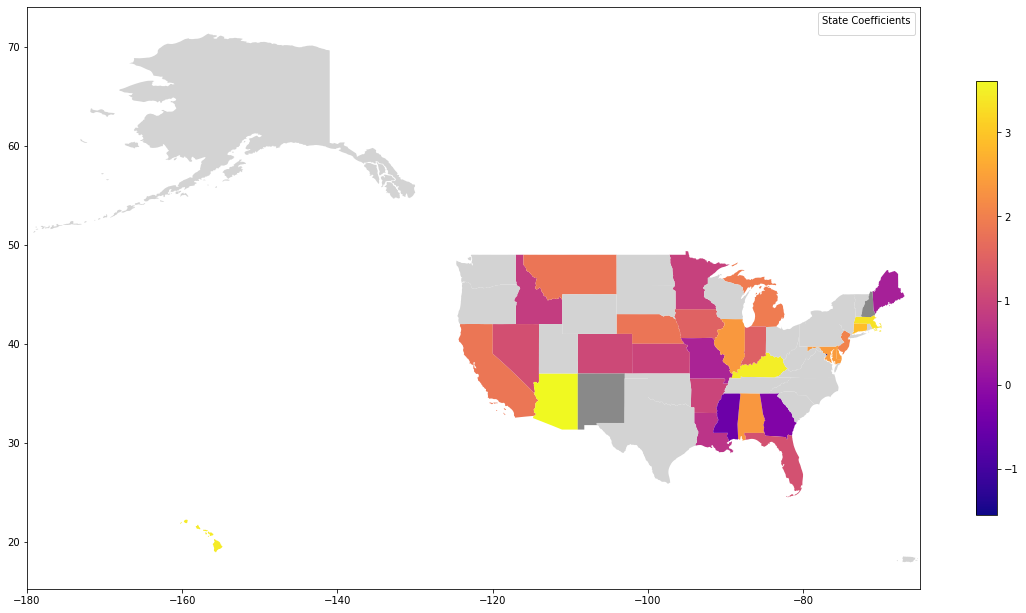

In [54]:
# plot state model coefficients

f, ax = plt.subplots(figsize=(20,20))

state_mod_geo[(state_mod_geo['P-Values']< 0.05)].plot(column='Coefficient', ax=ax, k=5, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})
state_mod_geo[state_mod_geo.isna().any(axis=1)].plot(ax=ax, color='#D3D3D3') # make missing values grey
state_mod_geo[(state_mod_geo['P-Values']> 0.05)].plot(ax=ax, color='#898989') # make insiginificant values dark grey

# adjust x axis, add legend label
plt.xlim([-180, -65])
ax.legend(title='State Coefficients')

# save figure
plt.savefig('state model coefficients.png')

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

(-180.0, -65.0)

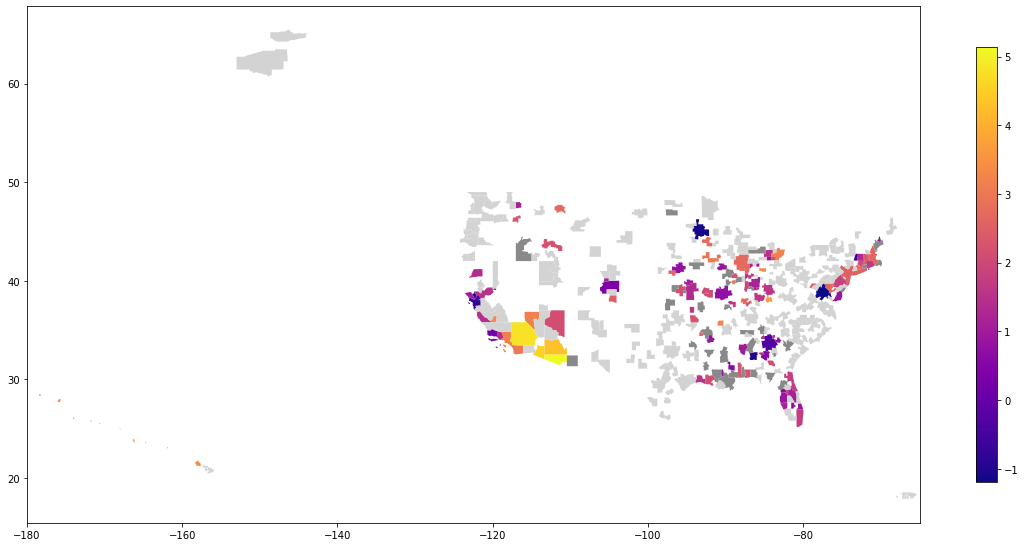

In [50]:
# plot MSA model coefficients
f, ax = plt.subplots(figsize=(20,20))

MSA_mod_geo[(MSA_mod_geo['P-Values']< 0.05)].plot(column='Coefficient', ax=ax, k=5, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})
MSA_mod_geo[MSA_mod_geo.isna().any(axis=1)].plot(ax=ax, color='#D3D3D3') # make missing values grey
MSA_mod_geo[(MSA_mod_geo['P-Values']> 0.05)].plot(ax=ax, color='#898989') # make insiginificant values dark grey

# adjust x axis, add legend
plt.xlim([-180, -65])
ax.legend(title='MSA Coefficients')

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

(-132.0, -65.0)

(22.0, 50.0)

No handles with labels found to put in legend.


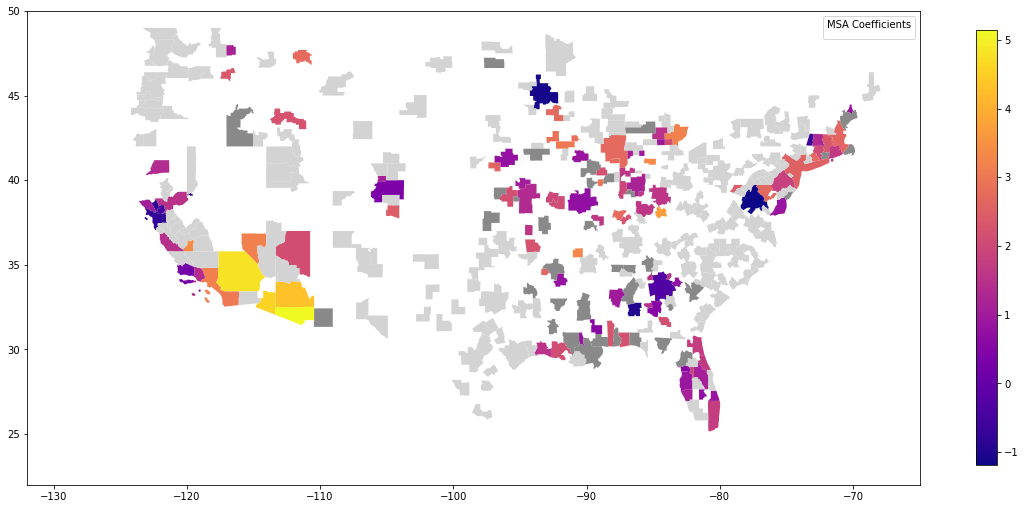

In [61]:
# plot MSA model coefficients (only the contiguous US)
f, ax = plt.subplots(figsize=(20,20))

MSA_mod_geo[(MSA_mod_geo['P-Values']< 0.05)].plot(column='Coefficient', ax=ax, k=5, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})
MSA_mod_geo[MSA_mod_geo.isna().any(axis=1)].plot(ax=ax, color='#D3D3D3') # make missing values grey
MSA_mod_geo[(MSA_mod_geo['P-Values']> 0.05)].plot(ax=ax, color='#898989') # make insiginificant values dark grey

# adjust x axis, add legend label
plt.xlim([-132, -65])
plt.ylim([22, 50])
ax.legend(title='MSA Coefficients')
         
# save figure
plt.savefig('MSA model coefficients.png')